# IPT

In [112]:
using PyPlot
using LaTeXStrings
using QuadGK
using FastGaussQuadrature
using TensorOperations
using Einsum
using LinearAlgebra
import PyCall: pyimport
sparse_ir = pyimport("sparse_ir")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")

rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.size"] = 16
rcParams["text.latex.preamble"] = raw"\usepackage{amsmath}"

"\\usepackage{amsmath}"

## Step 1: Generate IR basis and associated sampling points

In [113]:
lambda_ = 100
beta    = 10
basis   = sparse_ir.FiniteTempBasis("F", beta, lambda_/beta, eps=1e-10)
L = basis.size
# Sparse sampling in tau
smpl_tau = sparse_ir.TauSampling(basis)
print("cond (tau): ", smpl_tau.cond)

# Sparse sampling in Matsubara frequencies
smpl_matsu = sparse_ir.MatsubaraSampling(basis)
print("cond (matsu): ", smpl_matsu.cond)

cond (tau): 5.89770217368647cond (matsu): 11.266380245503292

## Step 2
Define a non-interacting DOS:
$$
\rho(\omega) = \frac{\sqrt{4-\omega^2}}{2\pi}.
$$

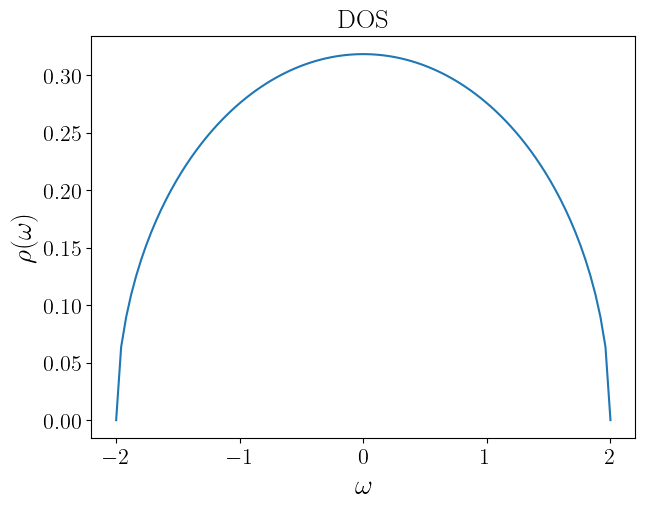

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [114]:
function rho_omega(omega)
    return sqrt(4-omega^2)/(2*pi)
end

@assert abs(quadgk(rho_omega,-2,2)[1]-1) < 1e-9

num_omega = 100
omegas = collect(range(-2,2,num_omega))
plt.figure()
plt.plot(omegas,rho_omega.(omegas))
plt.tight_layout()
plt.title("DOS")
fontsize = 20
plt.xlabel(L"$\omega$",fontsize=fontsize)
plt.ylabel(L"$\rho(\omega)$",fontsize=fontsize)
plt.show()

In [115]:
module IPT
import PyCall: pyimport
sparse_ir = pyimport("sparse_ir")
using FastGaussQuadrature

function rho_omega(omega)
    return sqrt(4-omega^2)/(2*pi)
end

function scale_quad(x, w, x_min, x_max)
    @assert x_min < x_max
    dx = x_max - x_min
    x_ = 0.5 .* dx .* (x .+ 1) .+ x_min
    w_ = 0.5 .* dx .* w
    return x_, w_
end

struct IPTSolver
    U::Float64
    basis
    beta::Float64
    rho_omega
    omega_range::Tuple{Float64,Float64}
    quad_rule
    smpl_matsu
    smpl_tau
end

function IPTSolver(U,basis,rho_omega,omega_range,deg_leg_gauss=1000)
    @assert omega_range[1] < omega_range[2]
    x_,w_ = gausslegendre(deg_leg_gauss)
    quad_rule = scale_quad(x_,w_,omega_range[1],omega_range[2])
    smpl_matsu = sparse_ir.MatsubaraSampling(basis)
    smpl_tau = sparse_ir.TauSampling(basis)

    return IPTSolver(U,basis,basis.beta,rho_omega,omega_range,quad_rule,smpl_matsu,smpl_tau)
end

U = 2.0
omega_range = (-2.0,2.0)
lambda_ = 100
beta    = 10
basis   = sparse_ir.FiniteTempBasis("F", beta, lambda_/beta, eps=1e-10)

solver = IPTSolver(U,basis,rho_omega,omega_range)
    
end

Main.IPT

In [116]:
D = 2
temp = 0.1/D
beta = 10*D
wmax = 10.0 * D
eps = 1e-9

basis = sparse_ir.FiniteTempBasis("F",beta,wmax,eps=eps)
L = basis.size

# Sparse sampling in tau
smpl_tau = sparse_ir.TauSampling(basis)
println("cond (tau): ", smpl_tau.cond)

# Sparse sampling in Matsubara frequencies
smpl_matsu = sparse_ir.MatsubaraSampling(basis)
println("cond (matsu): ", smpl_matsu.cond)

cond (tau): 11.408396757532548
cond (matsu): 17.755472692037568


In [117]:
println(smpl_matsu.sampling_points)

[-879, -837, -795, -339, -201, -137, -101, -75, -59, -45, -35, -29, -23, -19, -15, -13, -11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15, 19, 23, 29, 35, 45, 59, 75, 101, 137, 201, 339, 795, 837, 879]


## Self-consistent equation

$$
\begin{align*}
  G_\mathrm{loc}(\mathrm{i}\nu) &= \int \mathrm{d}\omega \frac{\rho(\omega)}{\mathrm{i}\nu - \omega - \Sigma(\mathrm{i}\nu)}\\
  \mathcal{G}(\mathrm{i}\nu) &= (G^{-1}_{\mathrm{loc}}(\mathrm{i}\nu) + \Sigma(\mathrm{i}\nu))^{-1}\\
  \Sigma(\tau) &= U^2 \mathcal{G}(\tau)^2 \mathcal{G}(\beta-\tau)
\end{align*}
$$

In [118]:
const newaxis = [CartesianIndex()]

1-element Vector{CartesianIndex{0}}:
 CartesianIndex()

In [119]:
function compute_gloc_iv(solver,sigma_iv)
    quad_points = solver.quad_rule[1]
    quad_weight = solver.quad_rule[2] 
    # sampling Matsubara frequencies
    iv = im .* solver.smpl_matsu.sampling_points .* (pi/solver.beta)
    gloc_iv = zeros(ComplexF64,length(iv))
    temp = (iv .- sigma_iv)[newaxis,:] .- quad_points[:,newaxis]

    for j in 1:length(iv)
        for i in 1:length(quad_points)
            gloc_iv[j] += quad_weight[i] * solver.rho_omega.(quad_points)[i] / temp[i,j]
        end
    end

    #@tensor gloc_iv[j] = quad_weight[i] * solver.rho_omega.(quad_points)[i] * (1 ./ temp)[i,j] 

    return gloc_iv
end

len_iv = length(solver.smpl_matsu.sampling_points)
sigma_iv = zeros(ComplexF64,len_iv)
gloc_iv = compute_gloc_iv(solver,sigma_iv)

32-element Vector{ComplexF64}:
  2.7489231239054475e-21 + 0.013897310458286651im
 -1.4210374042150712e-20 + 0.014665503466246812im
   1.663382340544285e-20 + 0.03418686712409238im
  -6.328324596821624e-20 + 0.05768196415180551im
  -2.943653524692192e-19 + 0.08108134827108833im
    5.90776322593282e-19 + 0.1084705842600468im
  -3.278226368978812e-19 + 0.13584178982805456im
  -7.574043089689999e-19 + 0.18110011577070237im
  -5.356676476695904e-18 + 0.20342510578177503im
 -1.7864520427634232e-18 + 0.2317079136786483im
  -6.707395828955688e-18 + 0.2685096074396494im
  5.8631777773259055e-18 + 0.31792844610473436im
    3.63699569374868e-17 + 0.3867219997228807im
                         ⋮
  5.8631777773259055e-18 - 0.31792844610473436im
  -6.707395828955688e-18 - 0.2685096074396494im
 -1.7864520427634232e-18 - 0.2317079136786483im
  -5.356676476695904e-18 - 0.20342510578177503im
  -7.574043089689999e-19 - 0.18110011577070237im
  -3.278226368978812e-19 - 0.13584178982805456im
    5.907763225

In [120]:
function compute_g0_iv(solver,gloc_iv,sigma_iv)
    return 1 ./ ((1 ./ gloc_iv) .+ sigma_iv)
end

g0_iv = compute_g0_iv(solver,gloc_iv,sigma_iv)

32-element Vector{ComplexF64}:
  2.7489231239054475e-21 + 0.013897310458286651im
 -1.4210374042150712e-20 + 0.01466550346624681im
   1.663382340544285e-20 + 0.03418686712409238im
  -6.328324596821623e-20 + 0.0576819641518055im
  -2.943653524692192e-19 + 0.08108134827108833im
    5.90776322593282e-19 + 0.1084705842600468im
  -3.278226368978812e-19 + 0.13584178982805456im
  -7.574043089689999e-19 + 0.18110011577070237im
  -5.356676476695905e-18 + 0.20342510578177503im
 -1.7864520427634232e-18 + 0.23170791367864832im
  -6.707395828955688e-18 + 0.2685096074396494im
  5.8631777773259055e-18 + 0.31792844610473436im
    3.63699569374868e-17 + 0.3867219997228807im
                         ⋮
  5.8631777773259055e-18 - 0.31792844610473436im
  -6.707395828955688e-18 - 0.2685096074396494im
 -1.7864520427634232e-18 - 0.23170791367864832im
  -5.356676476695905e-18 - 0.20342510578177503im
  -7.574043089689999e-19 - 0.18110011577070237im
  -3.278226368978812e-19 - 0.13584178982805456im
    5.907763225

In [121]:
function compute_sigma_iv(solver,g0_iv)
    g0_IR = solver.smpl_matsu.fit(g0_iv, axis=0) # axis for Fourier transform
    g0_tau = solver.smpl_tau.evaluate(g0_IR)
    sigma_tau = solver.U^2 .* g0_tau.^2 .* reverse(g0_tau)
    sigma_IR = solver.smpl_tau.fit(sigma_tau)
    return solver.smpl_matsu.evaluate(sigma_IR,axis=0)
end

sigma_iv = compute_sigma_iv(solver,g0_iv)

32-element Vector{ComplexF64}:
 -1.0565507249646445e-15 + 0.01388065006239275im
  -1.073463162667871e-15 + 0.014645928613525332im
   7.538310907447799e-17 + 0.03394100193239812im
  -6.193837842334971e-17 + 0.05652296711424053im
   6.544120079189193e-17 + 0.07794863685936357im
 -1.7219443727385461e-16 + 0.1012718617386264im
  1.3072874437496554e-17 + 0.12238127033531916im
  -3.843857216892678e-16 + 0.15207291937616754im
   2.466092039865501e-17 + 0.1643117230589504im
 -1.3889083555978156e-16 + 0.1776187155939855im
  -7.441257752543015e-17 + 0.1914777510836235im
  -7.910504533196201e-17 + 0.20453792970507448im
  3.3333528891807556e-17 + 0.21365172178497793im
                         ⋮
  -6.657706539304719e-17 - 0.20453792970507442im
 -1.1604221318133044e-16 - 0.19147775108362344im
   9.495877317134956e-18 - 0.17761871559398545im
  -3.446886158888311e-16 - 0.16431172305895034im
  -1.659103014440653e-16 - 0.1520729193761675im
 -2.6140002566686136e-16 - 0.12238127033531913im
   6.4561360983

In [122]:
function mk_new_sigma_iv(solver,sigma_iv)
    gloc_iv = compute_gloc_iv(solver,sigma_iv)
    g0_iv = compute_g0_iv(solver,gloc_iv,sigma_iv)
    return compute_sigma_iv(solver,g0_iv)
end


mk_new_sigma_iv (generic function with 1 method)

In [123]:
function normalize_factor(solver,sigma_history,nitr,mixing) # What is normalize_factor?
    # initialize sigma_iv
    if length(sigma_history) == 0
        sigma_iv = zeros(ComplexF64,length(solver.smpl_matsu.sampling_points))
    else 
        sigma_iv = sigma_history[end]
    end
   
    # mixing sigma_iv with new_sigma_iv
    for i in 1:nitr
        new_sigma_iv = mk_new_sigma_iv(solver,sigma_iv)
        rdiff = maximum(abs.(new_sigma_iv .- sigma_iv)) / maximum(abs.(sigma_iv))
        #println(i,rdiff)
        if rdiff < 1e-5
            break
        end
        sigma_iv = mixing .* new_sigma_iv .+ (1-mixing) .* sigma_iv
    end

    center = Int(length(sigma_iv)/2) + 1 # julia 
    delta_sigma_iv = imag(sigma_iv[center]-sigma_iv[center-1])
    delta_sampling_points = solver.smpl_matsu.sampling_points[center] - solver.smpl_matsu.sampling_points[center-1] 
    inv_z = 1 - delta_sigma_iv/delta_sampling_points

    return 1/inv_z, sigma_iv
end


normalize_factor (generic function with 1 method)


$$
z = \frac{1}{1-\frac{\partial \Sigma}{\partial \omega}}
$$
Because a self-energy $\Sigma$ contains an effect of an on-site interaction $U$, then $z$ meets
$$
z\approx1 \ (U\ll1).
$$

In [124]:

function run(D,Us,rho_omega,omega_range,nitr,mixing)
    # make sparse ir basis
    beta = 10  * D
    wmax = 10.0 * D
    eps = 1e-9
    basis = sparse_ir.FiniteTempBasis("F", beta, wmax, eps=eps)

    Z = []
    sigma_history = []
    for iu in Us
        solver = IPT.IPTSolver(iu,basis,rho_omega,omega_range)
        println(solver.U)
        z, sigma_ = normalize_factor(solver,sigma_history,nitr,mixing) 
        push!(sigma_history,sigma_)
        if abs(z) > 1e-10
            push!(Z,z)
        else 
            break
        end
    end

    return Z, sigma_history
end

D = 2
num_U = 20
U_min = 5 / D
U_max = 6.5 / D
Us = 2 .* collect(range(U_min,U_max,num_U))
omega_range = (-2.0,2.0)
nitr = 1000
mixing = 0.1
Z,sigma_history = run(D,Us,rho_omega,omega_range,nitr,mixing)

5.0
5.078947368421052
5.157894736842105
5.2368421052631575
5.315789473684211
5.394736842105263
5.473684210526316
5.552631578947368
5.631578947368421
5.7105263157894735
5.7894736842105265
5.868421052631579
5.947368421052632
6.026315789473684
6.105263157894737
6.184210526315789
6.2631578947368425
6.342105263157895
6.421052631578948
6.5


(Any[0.5906632344276342, 0.5721199383364783, 0.5525585617301096, 0.5318291944362452, 0.5097204258850562, 0.48591743330190934, 0.4599026889870399, 0.4307147957720943, 0.3961399116907477, 0.3475742659979036, 0.03214016908270687, 0.03048125256034184, 0.028988902829590137, 0.027636177688159222, 0.02640214307626235, 0.02527025598612674, 0.024227185472336772, 0.023262066215305983, 0.022365801232970363, 0.02153080009617702], Any[ComplexF64[8.399906463102314e-15 + 0.045252805518977125im, 8.54466008242703e-15 + 0.04752214114878074im, 8.661791855617321e-15 + 0.05003101379008681im, -7.160343330047745e-16 + 0.11714364117210613im, 2.0406499850379814e-15 + 0.19687580941575658im, 2.518934751733505e-16 + 0.2870887587684795im, 8.548849901697101e-16 + 0.3858460365396033im, -8.398013337830424e-16 + 0.5116295396535345im, 1.329117782984803e-16 + 0.6377421416177158im, 9.469681621368615e-16 + 0.8089042148763546im  …  2.290738753240773e-15 - 0.8089042148763551im, -5.906673685549427e-16 - 0.6377421416177163im,

In [125]:
Z

20-element Vector{Any}:
 0.5906632344276342
 0.5721199383364783
 0.5525585617301096
 0.5318291944362452
 0.5097204258850562
 0.48591743330190934
 0.4599026889870399
 0.4307147957720943
 0.3961399116907477
 0.3475742659979036
 0.03214016908270687
 0.03048125256034184
 0.028988902829590137
 0.027636177688159222
 0.02640214307626235
 0.02527025598612674
 0.024227185472336772
 0.023262066215305983
 0.022365801232970363
 0.02153080009617702

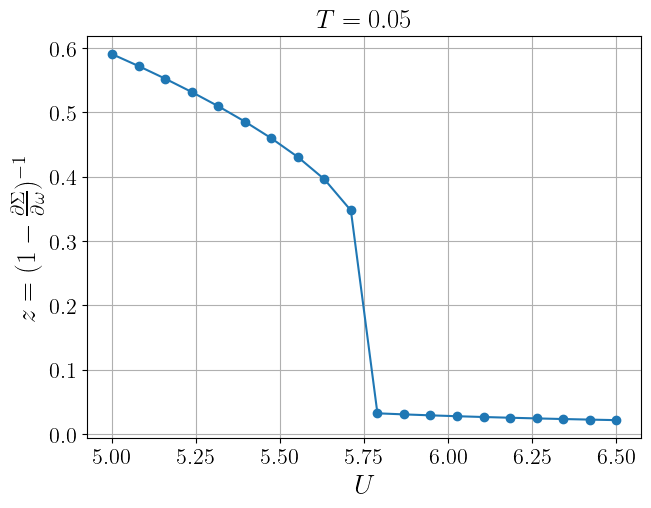

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [126]:
plt.figure()
plt.plot(Us,Z,marker="o")
plt.tight_layout()
plt.title("scaling plot before optimization in $(L"$J_2=1\times10^{-2},\ L=900$")")
plt.title(L"$T=0.05$")
fontsize = 20
plt.xlabel(L"$U$",fontsize=fontsize)
plt.ylabel(L"$z = (1-\frac{\partial \Sigma}{\partial \omega})^{-1}$",fontsize=fontsize)
plt.grid()
plt.savefig("test_iptsolver.pdf",bbox_inches="tight",transparent=true)
plt.show()